In [1]:
import os
import pandas as pd
from statistics import median, mean
import numpy as np
import scipy.stats as st
from sentiment import calc_accuracy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Image

# Figure Generation

In [2]:
pipelines = ["Cleaned Original Language", "Translated to English", "Translated Back to Original"]

### Figure 1

Comparison of Cleaned Original Language and Translated to English accuracies accross all languages.

In [3]:
# Distance between median and lower bound of 95% confidence interval
def lower_dist(i):
    return abs(data["Confidence"][i][0] - data["MedianAccuracy"][i])

# Distance between median and upper bound of 95% confidence interval
def upper_dist(i):
    return abs(data["Confidence"][i][1] - data["MedianAccuracy"][i])

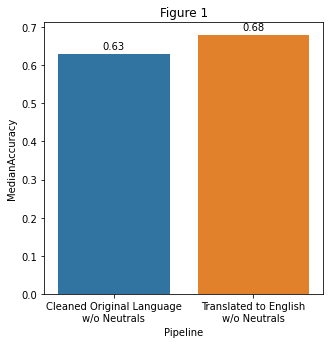

In [4]:
data = pd.DataFrame({"Pipeline": [pipelines[0] + "\nw/o Neutrals", pipelines[1] + "\nw/o Neutrals"], 
                     "MedianAccuracy": [0.6292841870731398, 0.6773197763343846],
                     "Confidence": [[0.6292436847905679, 0.6293344412681997], [0.6772634997154882, 0.6773889914107322]]})

plt.rcParams["figure.figsize"] = (5,5)

lower_dists = list(map(lower_dist, [0,1]))
upper_dists = list(map(upper_dist, [0,1]))

bp = sns.barplot(
    data=data,
    x="Pipeline",
    y="MedianAccuracy",
    yerr=[lower_dists, upper_dists])

bp.set_title("Figure 1")

for bar in bp.patches:
    bp.annotate(format(bar.get_height(), '.2f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points')

plt.savefig("Figures/figure1.png", bbox_inches="tight")

### Figure 2

Comparison of Cleaned Original Language and Translated Back to Original Language accuracies accross all languages.

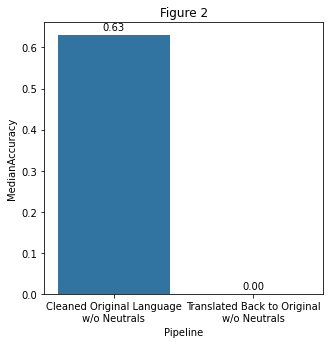

In [5]:
data = pd.DataFrame({"Pipeline": [pipelines[0] + "\nw/o Neutrals", pipelines[2] + "\nw/o Neutrals"], 
                     "MedianAccuracy": [0.6292841870731398, 0],
                     "Confidence": [[0.6292436847905679, 0.6293344412681997], [0, 0]]})

lower_dists = list(map(lower_dist, [0,1]))
upper_dists = list(map(upper_dist, [0,1]))

bp = sns.barplot(
    data=data,
    x="Pipeline",
    y="MedianAccuracy",
    yerr=[lower_dists, upper_dists])

bp.set_title("Figure 2")

for bar in bp.patches:
    bp.annotate(format(bar.get_height(), '.2f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points')

plt.savefig("Figures/figure2.png", bbox_inches="tight")

### Figure 3

In [6]:
data = { "Albanian" :   [0.6907679242994056, 0.7255703422053232, 0.6785111082239834],
         "Bosnian" :    [0.6101055226064854, 0.6535728130249386, 0.6233466625653645],
         "Bulgarian" :  [0.6708535739070091, 0.6877403476388247, 0.6732589348778076],
         "Croatian" :   [0.6717483751905641, 0.7402111890863776, 0.6762798239518184],
         "English" :    [0.7943662985214232, 0                 , 0                 ],
         "German" :     [0.6713624471724693, 0.7073111488948264, 0.6824258104982556],
         "Hungarian" :  [0.6520987791961648, 0.748172757475083,  0.6537959822593269],
         "Polish" :     [0.6594672832196093, 0.6935362504232665, 0.6669599816359324],
         "Portuguese" : [0.6241413852318259, 0.6111249766019842, 0.6370149253731343],
         "Russian" :    [0.5814561714333923, 0.5825926728809885, 0.6057541957677474],
         "Serbian" :    [0.6506550218340611, 0.507029053420806,  0.4934800702857671],
         "Slovak" :     [0.6407723645292706, 0.6893227283682816, 0.6459887668706513],
         "Slovenian" :  [0.7167278316238512, 0.5714285714285714, 0.729204807768845 ],
         "Spanish" :    [0.5011172334725488, 0.7581346375925548, 0.46990518357629174],
         "Swedish" :    [0.5963507303089594, 0.5538045208532315, 0.6115641215715345] }

In [7]:
def create_barchart(lang) -> None:
    bp = sns.barplot(x=[pipelines[1], pipelines[0], pipelines[2]], 
                     y=[data[lang][1], data[lang][0], data[lang][2]])

    for bar in bp.patches:
        bp.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                        size=10, xytext=(0, 8),
                        textcoords='offset points')
    
    plt.rcParams["figure.figsize"] = (3,3)
    
    # Hide x axis labels
    bp.set(xticklabels=[])
    
    plt.ylim(0, 0.9)
    plt.ylabel("Accuracy")
    plt.title(lang)

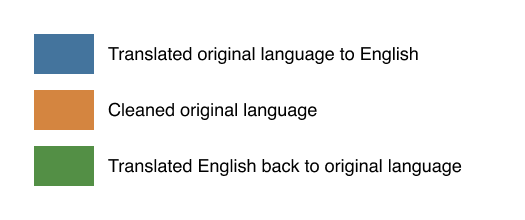

In [8]:
Image(filename="Figures/legend.png") 

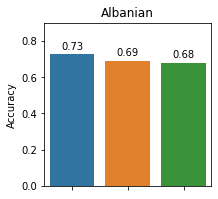

In [9]:
plt.rcParams["figure.figsize"] = (3,3)
create_barchart("Albanian")
plt.savefig("Figures/figure3-1.png", bbox_inches="tight")

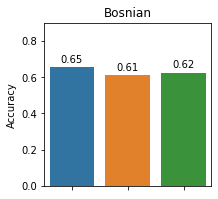

In [10]:
create_barchart("Bosnian")
plt.savefig("Figures/figure3-2.png", bbox_inches="tight")

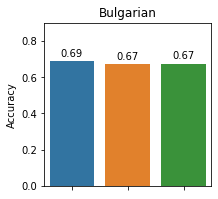

In [11]:
create_barchart("Bulgarian")
plt.savefig("Figures/figure3-3.png", bbox_inches="tight")

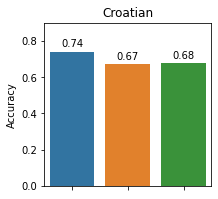

In [12]:
create_barchart("Croatian")
plt.savefig("Figures/figure3-4.png", bbox_inches="tight")

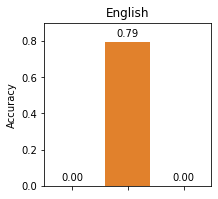

In [13]:
create_barchart("English")
plt.savefig("Figures/figure3-5.png", bbox_inches="tight")

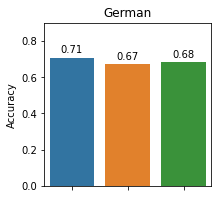

In [14]:
create_barchart("German")
plt.savefig("Figures/figure3-6.png", bbox_inches="tight")

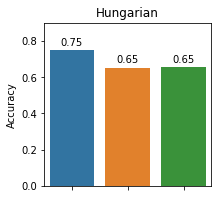

In [15]:
create_barchart("Hungarian")
plt.savefig("Figures/figure3-7.png", bbox_inches="tight")

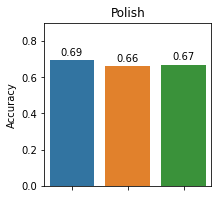

In [16]:
create_barchart("Polish")
plt.savefig("Figures/figure3-8.png", bbox_inches="tight")

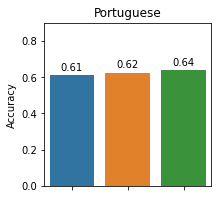

In [17]:
create_barchart("Portuguese")
plt.savefig("Figures/figure3-9.png", bbox_inches="tight")

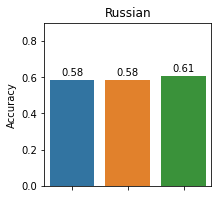

In [18]:
create_barchart("Russian")
plt.savefig("Figures/figure3-10.png", bbox_inches="tight")

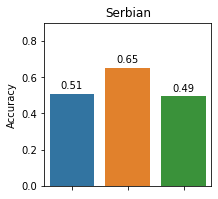

In [19]:
create_barchart("Serbian")
plt.savefig("Figures/figure3-11.png", bbox_inches="tight")

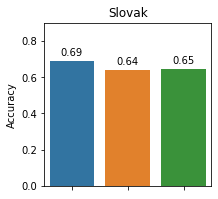

In [20]:
create_barchart("Slovak")
plt.savefig("Figures/figure3-12.png", bbox_inches="tight")

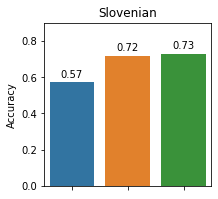

In [21]:
create_barchart("Slovenian")
plt.savefig("Figures/figure3-13.png", bbox_inches="tight")

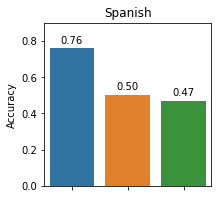

In [22]:
create_barchart("Spanish")
plt.savefig("Figures/figure3-14.png", bbox_inches="tight")

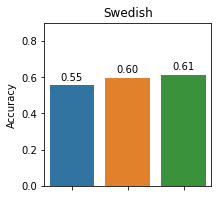

In [23]:
create_barchart("Swedish")
plt.savefig("Figures/figure3-15.png", bbox_inches="tight")

### Figure 4

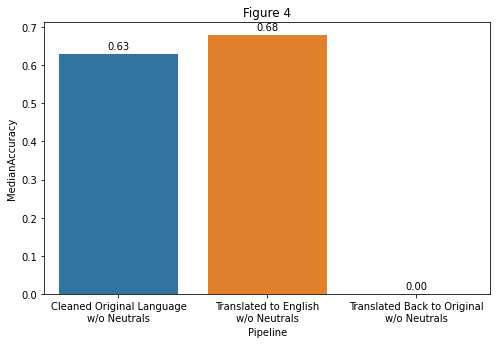

In [24]:
data = pd.DataFrame({"Pipeline": [pipelines[0] + "\nw/o Neutrals", pipelines[1] + "\nw/o Neutrals", pipelines[2] + "\nw/o Neutrals"], 
                     "MedianAccuracy": [0.6292841870731398, 0.6773197763343846, 0],
                     "Confidence": [[0.6292436847905679, 0.6293344412681997], [0.6772634997154882, 0.6773889914107322], [0, 0]]})

plt.rcParams["figure.figsize"] = (8,5)

lower_dists = list(map(lower_dist, [0,1,2]))
upper_dists = list(map(upper_dist, [0,1,2]))

bp = sns.barplot(
    data=data,
    x="Pipeline",
    y="MedianAccuracy",
    yerr=[lower_dists, upper_dists])

bp.set_title("Figure 4")

for bar in bp.patches:
    bp.annotate(format(bar.get_height(), '.2f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 8),
                textcoords='offset points')

plt.savefig("Figures/figure4.png", bbox_inches="tight")

In [25]:
data = { "Albanian" :   [0.413501464224835,   0.39837842563049086, 0.3993837143231785],
         "Bosnian" :    [0.39346542448497573, 0.37777194593885316, 0.3972444561081223],
         "Bulgarian" :  [0.4645075631845986,  0.47064030221126335, 0.46453917524143706],
         "Croatian" :   [0.34938869775359815, 0.3219247389912025,  0.3543291151295818],
         "English" :    [0.5269707645148007,  0                 ,  0                 ],
         "German" :     [0.4714950790215216,  0.5161105892922775,  0.46807489688406095],
         "Hungarian" :  [0.40099467760230345, 0.3930896082366286,  0.40926620713724804],
         "Polish" :     [0.3694263533579951,  0.38659928098786017, 0.370973792528526 ],
         "Portuguese" : [0.3985451484119624,  0.38915306853982096, 0.3219483961773972],
         "Russian" :    [0.4006279401206588,  0.4063072620310541,  0.4059750752778046],
         "Serbian" :    [0.4262071080994409,  0.41759038496395756, 0.3577752680525927],
         "Slovak" :     [0.3619023311213204,  0.2890079972775225,  0.31075378594521014],
         "Slovenian" :  [0.45431260635280774, 0.4127818349404424,  0.4236386840612592 ],
         "Spanish" :    [0.33478413749335345, 0.4109063309377198,  0.3542606473302345],
         "Swedish" :    [0.4073310245534846,  0.3190396513483015,  0.341122222654578 ] }

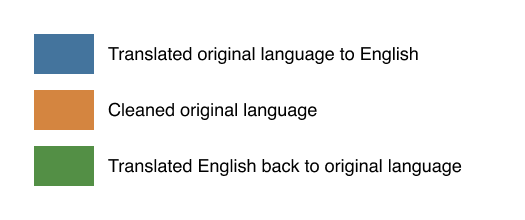

In [26]:
Image(filename="Figures/legend.png") 

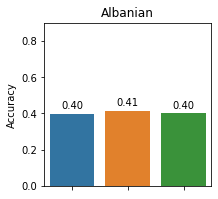

In [27]:
plt.rcParams["figure.figsize"] = (3,3)
create_barchart("Albanian")
plt.savefig("Figures/figure4-1.png", bbox_inches="tight")

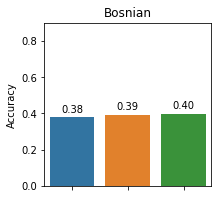

In [28]:
create_barchart("Bosnian")
plt.savefig("Figures/figure4-2.png", bbox_inches="tight")

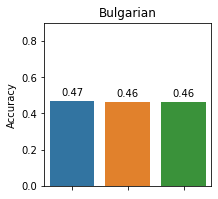

In [29]:
create_barchart("Bulgarian")
plt.savefig("Figures/figure4-3.png", bbox_inches="tight")

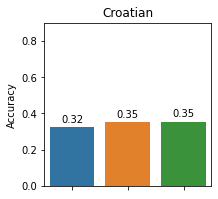

In [30]:
create_barchart("Croatian")
plt.savefig("Figures/figure4-4.png", bbox_inches="tight")

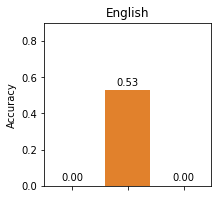

In [31]:
create_barchart("English")
plt.savefig("Figures/figure4-5.png", bbox_inches="tight")

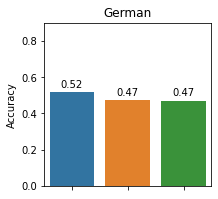

In [32]:
create_barchart("German")
plt.savefig("Figures/figure4-6.png", bbox_inches="tight")

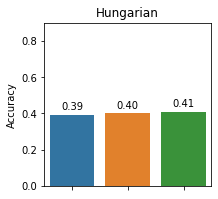

In [33]:
create_barchart("Hungarian")
plt.savefig("Figures/figure4-7.png", bbox_inches="tight")

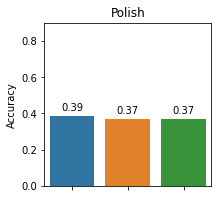

In [34]:
create_barchart("Polish")
plt.savefig("Figures/figure4-8.png", bbox_inches="tight")

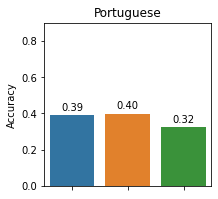

In [35]:
create_barchart("Portuguese")
plt.savefig("Figures/figure4-9.png", bbox_inches="tight")

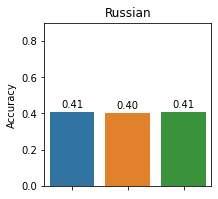

In [36]:
create_barchart("Russian")
plt.savefig("Figures/figure4-10.png", bbox_inches="tight")

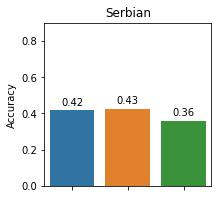

In [37]:
create_barchart("Serbian")
plt.savefig("Figures/figure4-11.png", bbox_inches="tight")

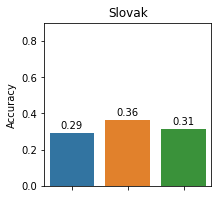

In [38]:
create_barchart("Slovak")
plt.savefig("Figures/figure4-12.png", bbox_inches="tight")

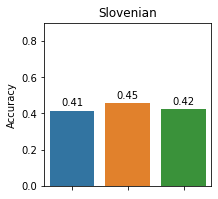

In [39]:
create_barchart("Slovenian")
plt.savefig("Figures/figure4-13.png", bbox_inches="tight")

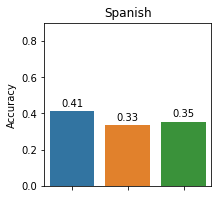

In [40]:
create_barchart("Spanish")
plt.savefig("Figures/figure4-14.png", bbox_inches="tight")

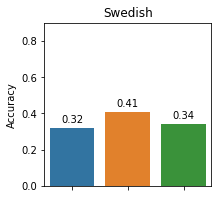

In [41]:
create_barchart("Swedish")
plt.savefig("Figures/figure4-15.png", bbox_inches="tight")

# Increase/Decrease

In [42]:
increased = []
decreased = []
for key, value in data.items():
    if key == "English":
        continue
    if value[0] < value[2]:
        increased.append((key, value[2] - value[0]))
    else:
        decreased.append((key, value[2] - value[0]))

print("Increased between Pipeline 1 and Pipeline 3")
print(*increased, sep='\n')
print("Decreased between Pipeline 1 and Pipeline 3")
print(*decreased, sep='\n')

Increased between Pipeline 1 and Pipeline 3
('Bosnian', 0.003779031623146578)
('Bulgarian', 3.161205683843704e-05)
('Croatian', 0.004940417375983663)
('Hungarian', 0.008271529534944588)
('Polish', 0.0015474391705309065)
('Russian', 0.005347135157145799)
('Spanish', 0.01947650983688104)
Decreased between Pipeline 1 and Pipeline 3
('Albanian', -0.01411774990165654)
('German', -0.003420182137460648)
('Portuguese', -0.07659675223456525)
('Serbian', -0.06843184004684821)
('Slovak', -0.05114854517611028)
('Slovenian', -0.030673922291548528)
('Swedish', -0.0662088018989066)


In [43]:
increased = []
decreased = []
for key, value in data.items():
    if key == "English":
        continue
    if value[0] < value[1]:
        increased.append((key, value[1] - value[0]))
    else:
        decreased.append((key, value[1] - value[0]))

print("Increased between Pipeline 1 and Pipeline 2")
print(*increased, sep='\n')
print("Decreased between Pipeline 1 and Pipeline 2")
print(*decreased, sep='\n')

Increased between Pipeline 1 and Pipeline 2
('Bulgarian', 0.006132739026664724)
('German', 0.04461551027075589)
('Polish', 0.017172927629865054)
('Russian', 0.00567932191039533)
('Spanish', 0.07612219344436633)
Decreased between Pipeline 1 and Pipeline 2
('Albanian', -0.015123038594344163)
('Bosnian', -0.015693478546122575)
('Croatian', -0.027463958762395657)
('Hungarian', -0.007905069365674866)
('Portuguese', -0.009392079872141468)
('Serbian', -0.00861672313548334)
('Slovak', -0.0728943338437979)
('Slovenian', -0.04153077141236533)
('Swedish', -0.0882913732051831)


In [44]:
increased = []
decreased = []
for key, value in data.items():
    if key == "English":
        continue
    if value[1] < value[2]:
        increased.append((key, value[2] - value[1]))
    else:
        decreased.append((key, value[2] - value[1]))

print("Increased between Pipeline 2 and Pipeline 3")
print(*increased, sep='\n')
print("Decreased between Pipeline 2 and Pipeline 3")
print(*decreased, sep='\n')

Increased between Pipeline 2 and Pipeline 3
('Albanian', 0.0010052886926876226)
('Bosnian', 0.019472510169269153)
('Croatian', 0.03240437613837932)
('Hungarian', 0.016176598900619454)
('Slovak', 0.021745788667687616)
('Slovenian', 0.010856849120816803)
('Swedish', 0.0220825713062765)
Decreased between Pipeline 2 and Pipeline 3
('Bulgarian', -0.006101126969826287)
('German', -0.048035692408216535)
('Polish', -0.015625488459334147)
('Portuguese', -0.06720467236242378)
('Russian', -0.0003321867532495304)
('Serbian', -0.059815116911364874)
('Spanish', -0.056645683607485287)
